In [ ]:
# Importando bibliotecas

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

!pip install scikit-posthocs
import scikit_posthocs as sp
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

%pip install sktime
%pip install pmdarima

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series


import missingno as msno
sns.set()

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
    matplotlib.rcParams['figure.figsize'] = [width * 3, height]
  
pd.set_option('display.float_format',  '{:,.8f}'.format)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = r'/content/drive/MyDrive/A3 Data/ocorrencia.csv'
ocorrencias_df = pd.read_csv(file_path)

file_path = r'/content/drive/MyDrive/A3 Data/aeronave.csv'
aeronaves_df = pd.read_csv(file_path)

### Limpeza de Dados

In [161]:
oc_df = ocorrencias_df.copy()
oc_df.fillna('N/A', inplace=True)
oc_df.replace('***', 'N/A', inplace=True)
oc_df.replace('****', 'N/A', inplace=True)
oc_df['dia_ocorrencia'] = pd.to_datetime(oc_df['dia_ocorrencia'])
oc_df['horario'] = pd.to_datetime(oc_df['horario'], format='%H:%M:%S').dt.hour

top_ocorrencias = oc_df['tipo'].value_counts().head(10).index.tolist()
top_ocorrencias.sort(reverse=True)

OUTROS = ['OUTROS ACIDENTES', 'OUTROS INCIDENTES GRAVES']

def categorize(tipo, classificacao):
    if tipo == 'OUTROS TIPOS' and classificacao == 'ACIDENTE':
        return 'OUTROS ACIDENTES'
    elif tipo == 'OUTROS TIPOS' and classificacao == 'INCIDENTE GRAVE':
        return 'OUTROS INCIDENTES GRAVES'

    if tipo in top_ocorrencias:
        return tipo
    elif classificacao == 'ACIDENTE':
        return 'OUTROS ACIDENTES'
    elif classificacao == 'INCIDENTE GRAVE':
        return 'OUTROS INCIDENTES GRAVES'

oc_df['categoria'] = oc_df.apply(lambda linha: categorize(linha['tipo'], linha['classificacao']), axis=1)


In [5]:
oc_df.head()

,codigo_ocorrencia,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,comando_investigador,status_investigacao,numero_relatorio,relatorio_publicado,dia_publicacao,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista,dia_extracao,categoria
0,47965,ACIDENTE,FALHA DO MOTOR EM VOO,ARIQUEMES,RO,BRASIL,SJOG,2013-05-05,11,N/A,SERIPA-7,N/A,N/A,N/A,N/A,0,1,N/A,2016-07-30,FALHA DO MOTOR EM VOO
1,50313,INCIDENTE GRAVE,POUSO SEM TREM,CACOAL,RO,BRASIL,SSKW,2013-11-25,12,SIM,SERIPA-7,FINALIZADA,IG-209/CENIPA/2013,1.00000000,2014-04-07,0,1,N/A,2016-07-30,POUSO SEM TREM
2,34078,ACIDENTE,PERDA DE CONTROLE NO SOLO,CEREJEIRAS,RO,BRASIL,N/A,2008-08-07,15,SIM,SERIPA-7,FINALIZADA,A - 517/CENIPA/2016,1.00000000,2016-07-07,0,1,1.00000000,2016-07-30,PERDA DE CONTROLE NO SOLO
3,44988,ACIDENTE,POUSO LONGO,AMAJARI,RR,BRASIL,N/A,2011-08-11,17,SIM,SERIPA-7,FINALIZADA,A-105/CENIPA/2012,1.00000000,2012-09-20,4,1,N/A,2016-07-30,OUTROS ACIDENTES
4,38855,ACIDENTE,PERDA DE CONTROLE EM VOO,ACEGUÁ,RS,BRASIL,N/A,2009-12-28,17,SIM,SERIPA-5,ATIVA,A DEFINIR,N/A,N/A,0,1,N/A,2016-07-30,PERDA DE CONTROLE EM VOO


## Análise Exploratória

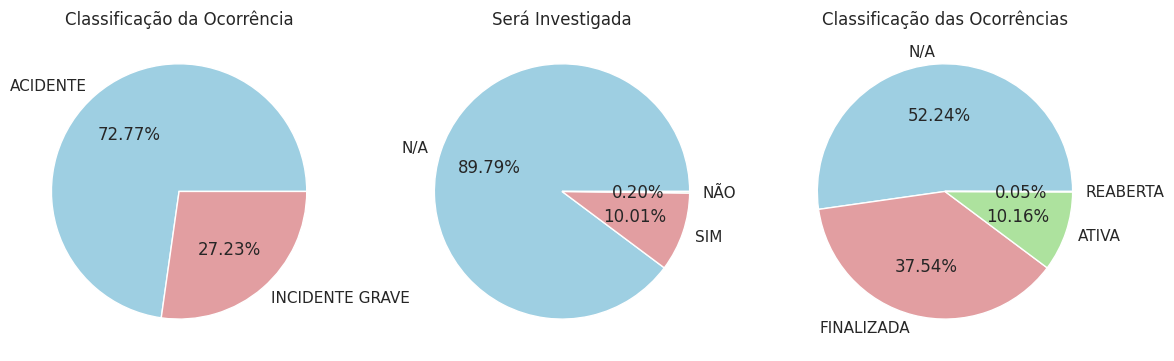

In [252]:
# create a histogram of the new column
atributes = ['classificacao','sera_investigada', 'status_investigacao']
titulos = ['Classificação da Ocorrência', "Será Investigada", "Status da Investigação"]

fig, axs = plt.subplots(1, len(atributes), figsize=(14, 20))
colors = ["#9ECFE2", "#E29EA1", '#ADE29E', '#A9CCE3']

for i in range(len(atributes)):
  ax = axs[i]
  att = atributes[i]
  titulo = titulos[i]
  ax.pie(oc_df[att].value_counts(dropna=False), autopct='%1.2f%%', labels = oc_df[att].unique(), colors = colors[:len(oc_df[att].unique())])
  ax.title.set_text(titulo)

plt.title('Classificação das Ocorrências')
plt.show()

In [163]:

counts = oc_df[['categoria', 'classificacao']].value_counts().sort_values(ascending=True).reset_index()
top_df = pd.DataFrame({'categoria': counts['categoria'], 'classificacao': counts['classificacao'], 'count': counts[0]})
top_df['cores'] = top_df['classificacao'].apply(lambda x: "#9ECFE2" if x == 'ACIDENTE' else "#E29EA1")

filtered_df = top_df.loc[(top_df['categoria'] == 'OUTROS INCIDENTES GRAVES') | (top_df['categoria'] == 'OUTROS ACIDENTES')]
filtered_df = filtered_df.sort_values(by='count')

top_df = top_df.loc[(top_df['categoria'] != 'OUTROS INCIDENTES GRAVES') & (top_df['categoria'] != 'OUTROS ACIDENTES')]
top_df = pd.concat([filtered_df, top_df])

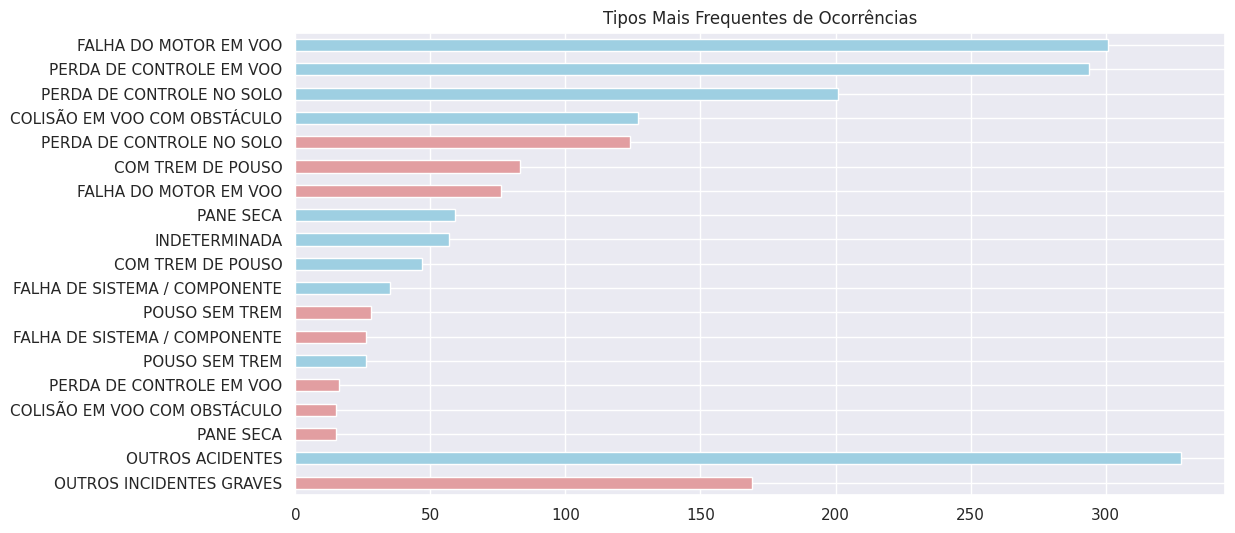

In [168]:
sns.set(rc={'figure.figsize':(12, 6)})

#fig, ax = plt.subplots()
#ax.barh(y=top_df['categoria'], width=top_df['count'], height=1, color=top_df['cores'])

ax = top_df.plot.barh(x='categoria', y='count', color=top_df['cores'], legend=False)
ax.set_ylabel("")
ax.set_title('Tipos Mais Frequentes de Ocorrências')


plt.show()

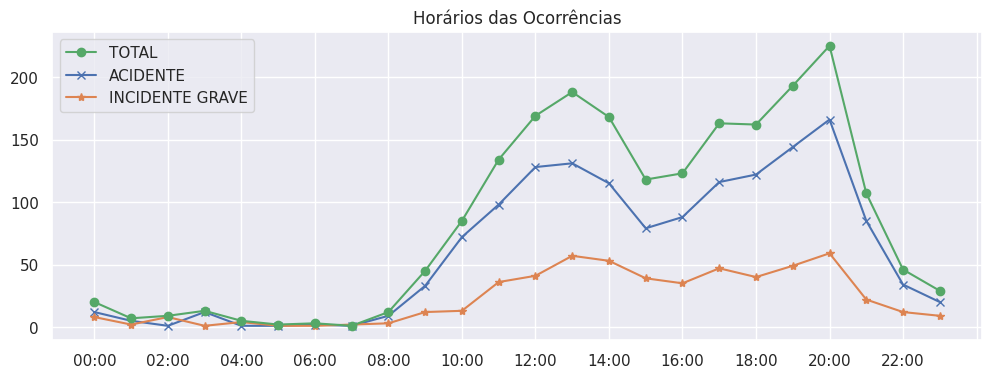

In [110]:

sns.set(rc={'figure.figsize':(12, 4)})

y = oc_df.groupby('horario').count()['codigo_ocorrencia']
z = oc_df.loc[oc_df['classificacao'] == 'ACIDENTE'].groupby('horario').count()['codigo_ocorrencia']
x = oc_df.loc[oc_df['classificacao'] == 'INCIDENTE GRAVE'].groupby('horario').count()['codigo_ocorrencia']

delta = pd.to_timedelta(y.index, unit='hours')
y.index = delta.components.hours.astype(str).str.zfill(2) + ':' + \
          delta.components.minutes.astype(str).str.zfill(2)

delta = pd.to_timedelta(z.index, unit='hours')
z.index = delta.components.hours.astype(str).str.zfill(2) + ':' + \
          delta.components.minutes.astype(str).str.zfill(2)

fig, ax = plt.subplots(1, 1)

p1 = ax.plot(z.index, z, marker='x')
p2 = ax.plot(x.index, x, marker='*')
p3 = ax.plot(y.index, y, marker='o')

ax.title.set_text("Horários das Ocorrências")
ax.xaxis.label.set_fontsize(1)
ax.xaxis.set_major_locator(plt.MaxNLocator(13))

plt.legend((p3[0], p1[0], p2[0]), ('TOTAL', 'ACIDENTE', 'INCIDENTE GRAVE'))

plt.show()

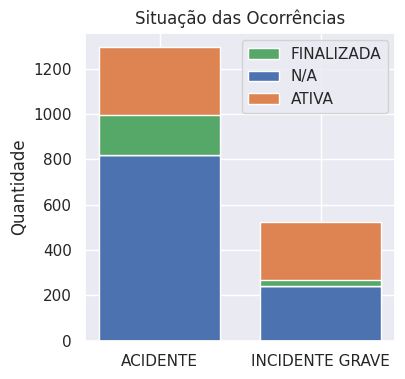

In [254]:
sns.set(rc={'figure.figsize':(4, 4)})

status = list(oc_df['classificacao'].unique())
ocorrencias = oc_df.groupby(['status_investigacao', 'classificacao']).count()

n_a = list(ocorrencias.loc[('N/A',)]['codigo_ocorrencia'])
finalizadas = list(ocorrencias.loc[('FINALIZADA',)]['codigo_ocorrencia'])
ativas = list(ocorrencias.loc[('ATIVA',)]['codigo_ocorrencia'])

width = 0.75

ind = np.arange(len(status))  

fig = plt.subplots()
p1 = plt.bar(ind, finalizadas, width)
p2 = plt.bar(ind, ativas, width, bottom = finalizadas)
p3 = plt.bar(ind, n_a, width, bottom = finalizadas)

plt.ylabel('Quantidade')
plt.title('Situação das Ocorrências')
plt.xticks(ind, status)
plt.legend((p3[0], p1[0], p2[0]), ('FINALIZADA', 'N/A', 'ATIVA'))
 
plt.show()

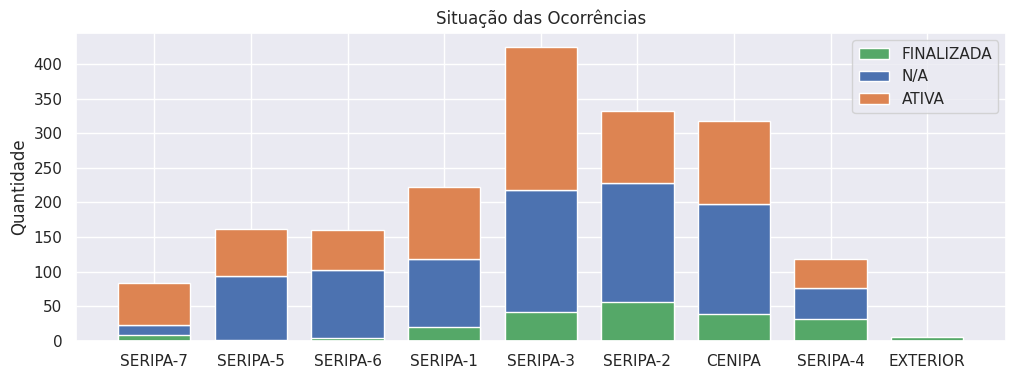

In [255]:
sns.set(rc={'figure.figsize':(12, 4)})

comandos = list(oc_df['comando_investigador'].unique())

ocorrencias = oc_df.groupby(['status_investigacao', 'comando_investigador']).count()

n_a = list(ocorrencias.loc[('N/A',)]['codigo_ocorrencia'])
finalizadas = list(ocorrencias.loc[('FINALIZADA',)]['codigo_ocorrencia'])
ativas = list(ocorrencias.loc[('ATIVA',)]['codigo_ocorrencia'])

width = 0.75 

ind = np.arange(len(comandos))  

fig = plt.subplots()

p1 = plt.bar(np.arange(len(finalizadas)) , finalizadas, width)
p2 = plt.bar(np.arange(len(ativas)), ativas, width, bottom = finalizadas)
p3 = plt.bar(np.arange(len(n_a)), n_a, width)

plt.ylabel('Quantidade')
plt.title('Situação das Ocorrências')
plt.xticks(ind, comandos)
plt.legend((p3[0], p1[0], p2[0]), ('FINALIZADA', 'N/A', 'ATIVA'))
 
plt.show()

## Análise Geográfica

In [ ]:
%pip install geopandas
%pip install contextily 
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

In [121]:
file_path = r'/content/drive/MyDrive/A3 Data/bcim_2016_21_11_2018.gpkg'
map = gpd.read_file(file_path, layer='lim_unidade_federacao_a')

file_path = r'/content/drive/MyDrive/A3 Data/airports.csv'
voos_df = pd.read_csv(file_path)

file_path = r'/content/drive/MyDrive/A3 Data/states.csv'
estados = pd.read_csv(file_path)

In [125]:
uf_df = oc_df.loc[(oc_df['uf'] != 'EX') & (oc_df['uf'] != 'N/A')].groupby('uf').count().reset_index()
uf_df = uf_df.rename(columns={'uf': 'sigla'})

estados = estados.rename(columns={'UF': 'sigla'})
voos_df = voos_df.rename(columns={'UF': 'sigla'})

In [154]:
passageiros = 109600000

estados_df = map.merge(uf_df[['sigla','codigo_ocorrencia']], on='sigla', how='left')
estados_df = estados_df.merge(voos_df, on='sigla', how='left')
estados_df = estados_df.merge(estados[['sigla','Population']], on='sigla', how='left')
estados_df['Num Passageiros'] = estados_df['Passengers rate'] * passageiros
estados_df['Num Passageiros'] = estados_df['Num Passageiros'].astype(int)
estados_df['acidentes_rate'] = estados_df['codigo_ocorrencia'] / estados_df['Num Passageiros']
estados_df['acidentes_rate'] = estados_df['acidentes_rate'] * 1000000

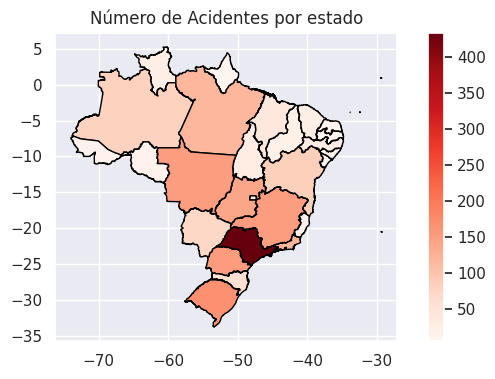

In [145]:
ax = estados_df.plot(column = 'codigo_ocorrencia', cmap = 'Reds', legend = True, edgecolor = 'black')
plt.title("Número de Acidentes por estado")
ax.set_ylabel("")
plt.show()

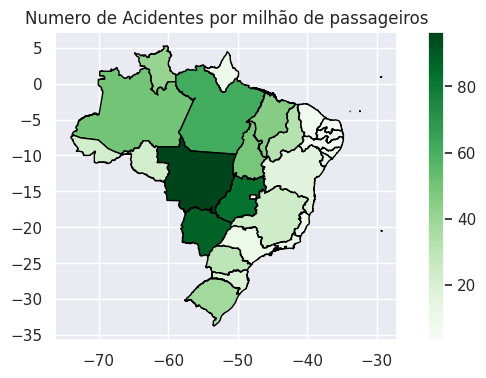

In [158]:
estados_df.plot(column = 'acidentes_rate', cmap = 'Greens', legend = True, edgecolor = 'black')
plt.title("Numero de Acidentes por milhão de passageiros")
plt.show()

## Análise de Evolução Temporal

In [187]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.ets import AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.utils.plotting import plot_series

### Data Preprocessing

In [170]:
time_df = oc_df.resample('M', on='dia_ocorrencia').count()
time_df = time_df.rename(columns={'codigo_ocorrencia': 'Quantidade Ocorrências'})

time_df.tail()

,Quantidade Ocorrências,classificacao,tipo,localidade,uf,pais,aerodromo,horario,sera_investigada,comando_investigador,status_investigacao,numero_relatorio,relatorio_publicado,dia_publicacao,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista,dia_extracao,categoria
dia_ocorrencia,,,,,,,,,,,,,,,,,,,
2015-08-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2015-09-30,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2015-10-31,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
2015-11-30,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
2015-12-31,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16


In [174]:
y = time_df['Quantidade Ocorrências']
decomp_y = seasonal_decompose(y, model='multiplicative')

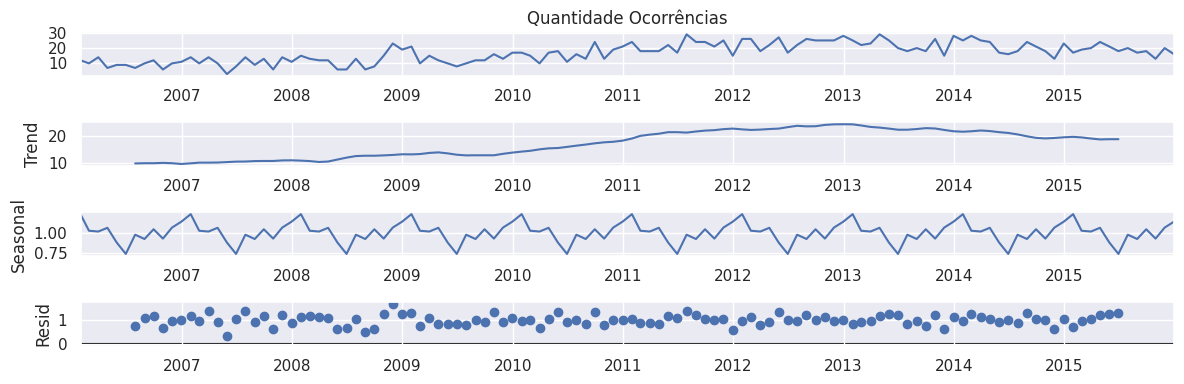

In [177]:
decomp_y.plot()
sns.set(rc={'figure.figsize':(12, 8)})

plt.show()

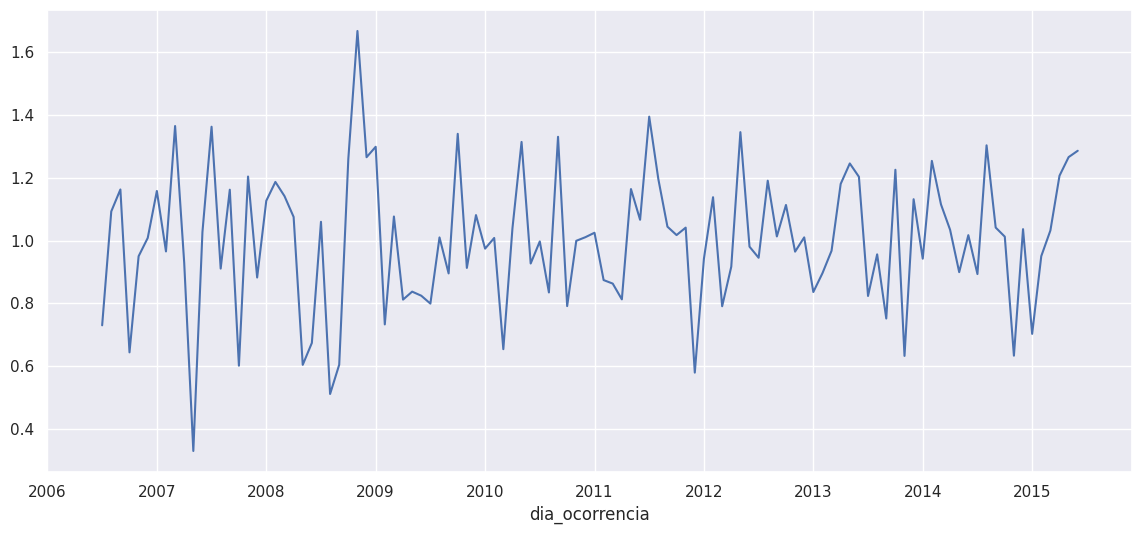

In [186]:
decomp_y.resid.plot()
sns.set(rc={'figure.figsize':(14, 6)})

plt.show()

In [200]:
residue = pd.Series(data=decomp_y.resid.fillna(0), index=time_df.index)
seasonal = pd.Series(data=decomp_y.seasonal.fillna(0), index=time_df.index)
trend = pd.Series(data=decomp_y.trend.fillna(0), index=time_df.index)

result = adfuller(residue)
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.8f}')
print(f'Critical Values: {result[4]}')

ADF Statistic: -4.0273
p-value: 0.00127392
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


In [198]:
residue.tail(10)

dia_ocorrencia
2015-03-31   1.03210638
2015-04-30   1.20643459
2015-05-31   1.26568333
2015-06-30   1.28592087
2015-07-31   0.00000000
2015-08-31   0.00000000
2015-09-30   0.00000000
2015-10-31   0.00000000
2015-11-30   0.00000000
2015-12-31   0.00000000
Freq: M, Name: resid, dtype: float64

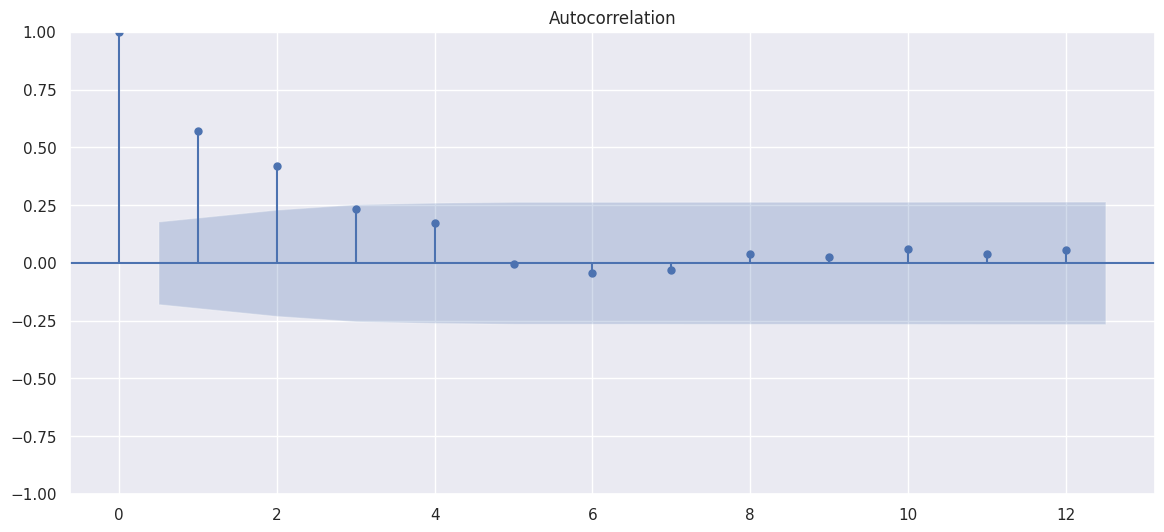

In [201]:
plot_acf(residue, lags = 12)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


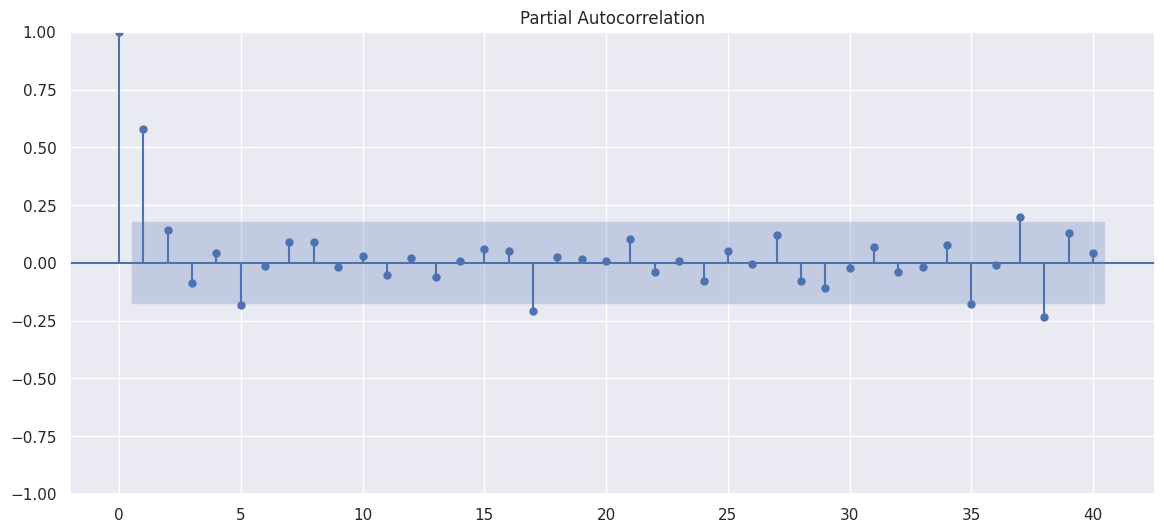

In [202]:
plot_pacf(residue, lags = 40)
plt.show()

In [203]:
def plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample):
  sns.set(rc={'figure.figsize':(15,5)})

  fig, ax = plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, 
              labels=["Treino", "Teste", "Prediçao à Frente", "Predição Dentro da Amostragem"])

  x_ticks = pd.date_range(start=y.index.min(), end=y.index.max(), freq='MS')
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))
  ax.title.set_text("Evolução na Quantidade de Ocorrências Mensais")
  ax.set_ylabel("")
  plt.show()

In [230]:
y_train, y_test = temporal_train_test_split(y, test_size=20)

In [231]:
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)  

cutoff = y_train.index[-1]
fh_rel = fh_abs.to_relative(cutoff)

cutoff_insample = y_test.index[-1]
fh_rel_insample = fh_abs.to_relative(cutoff_insample)

### Forecasting

#### ARIMA

In [232]:
forecaster = AutoARIMA(sp=12)
forecaster.fit(y_train)

y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/state

<ipython-input-203-30df11a6f6bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))


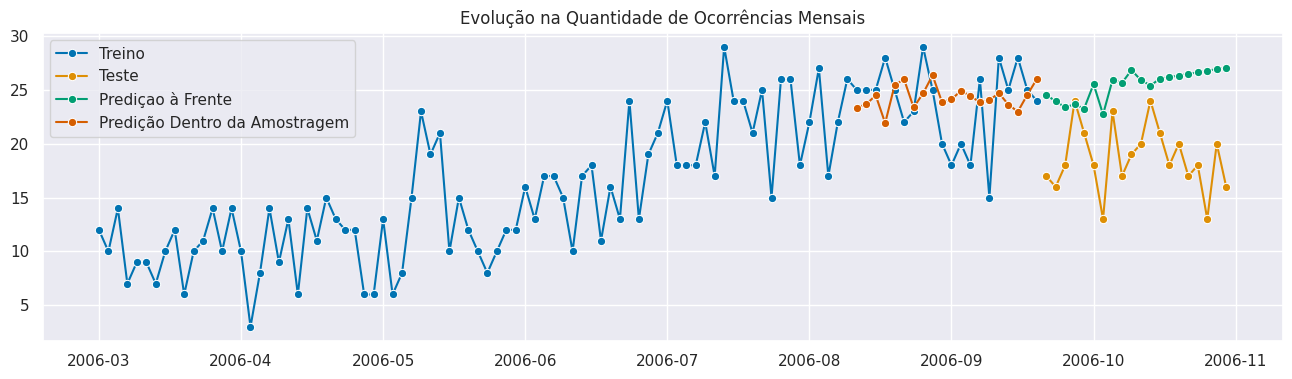

In [233]:
plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample)

In [234]:
results_arima = {
    "MSE": mean_squared_error(y_test, y_pred_rel), 
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_rel), 
    "R2 Score": r2_score(y_test, y_pred_rel)
}

#### STL Forecaster

In [235]:
forecaster = STLForecaster(sp=12)

forecaster.fit(y_train)

y_pred_rel = forecaster.predict(fh=fh_rel).fillna(0.0)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample).fillna(0.0)

results_stl = {
    "MSE": mean_squared_error(y_test, y_pred_rel), 
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_rel), 
    "R2 Score": r2_score(y_test, y_pred_rel)
}

<ipython-input-203-30df11a6f6bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))


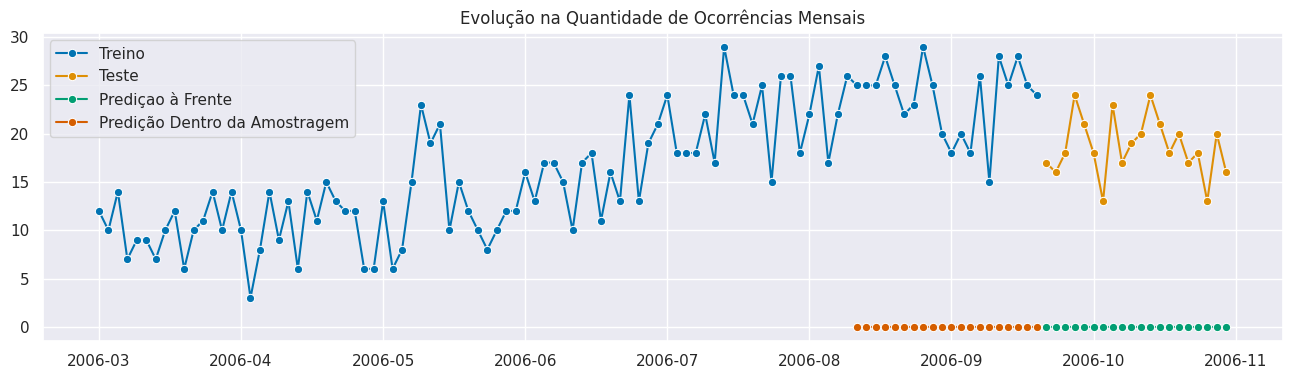

In [236]:
plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample)

#### Exponential Smoothing

In [237]:
forecaster = ExponentialSmoothing(trend="add", sp=12)

forecaster.fit(y_train)

y_pred_rel = forecaster.predict(fh=fh_rel).fillna(0.0)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample).fillna(0.0)

results_es = {
    "MSE": mean_squared_error(y_test, y_pred_rel), 
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_rel), 
    "R2 Score": r2_score(y_test, y_pred_rel)
}

<ipython-input-203-30df11a6f6bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))


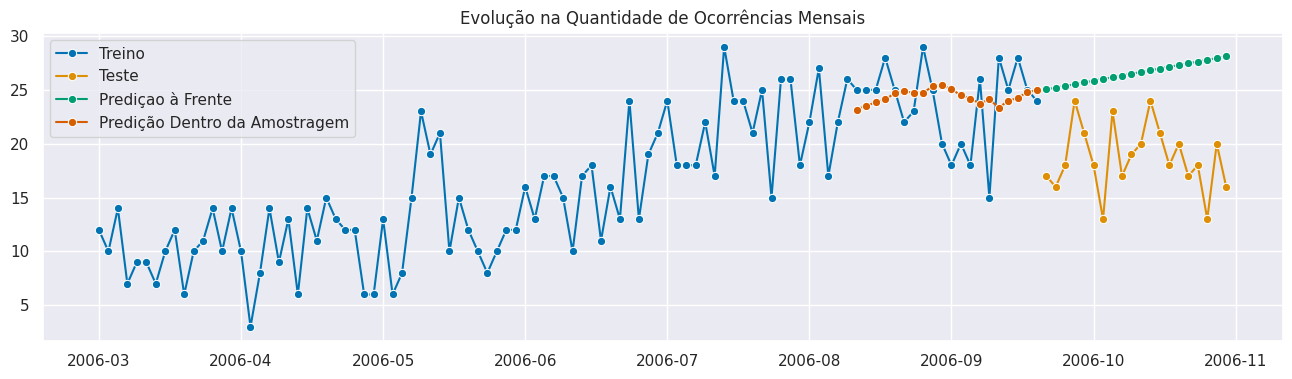

In [238]:
plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample)

#### Prophet

In [239]:
forecaster = Prophet(seasonality_mode='multiplicative',
    yearly_seasonality=True) 

forecaster.fit(y_train)

y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

results_fb = {
    "MSE": mean_squared_error(y_test, y_pred_rel), 
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_rel), 
    "R2 Score": r2_score(y_test, y_pred_rel)
}

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu4yzcjf4/fo4dozi7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu4yzcjf4/z3sb0aqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62003', 'data', 'file=/tmp/tmpu4yzcjf4/fo4dozi7.json', 'init=/tmp/tmpu4yzcjf4/z3sb0aqc.json', 'output', 'file=/tmp/tmpu4yzcjf4/prophet_model5uxtygwk/prophet_model-20230501054118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<ipython-input-203-30df11a6f6bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))


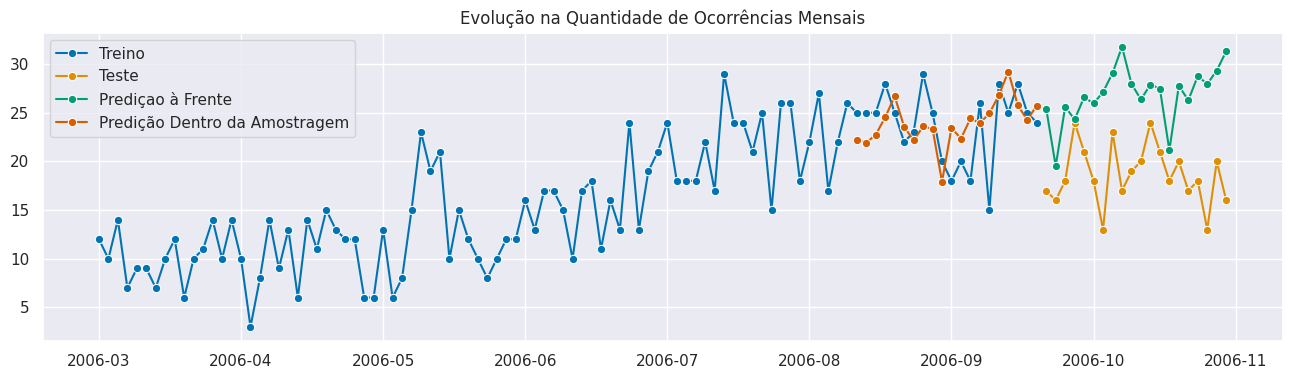

In [240]:
plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample)

#### Prophet

In [241]:
forecaster = Prophet(seasonality_mode='multiplicative',
    yearly_seasonality=True) 

forecaster.fit(y_train)

y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

results_fb = {
    "MSE": mean_squared_error(y_test, y_pred_rel), 
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_rel), 
    "R2 Score": r2_score(y_test, y_pred_rel)
}

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu4yzcjf4/_jsin8z7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu4yzcjf4/gpc3eeig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88090', 'data', 'file=/tmp/tmpu4yzcjf4/_jsin8z7.json', 'init=/tmp/tmpu4yzcjf4/gpc3eeig.json', 'output', 'file=/tmp/tmpu4yzcjf4/prophet_modelucf2nmho/prophet_model-20230501054118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:41:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<ipython-input-203-30df11a6f6bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))


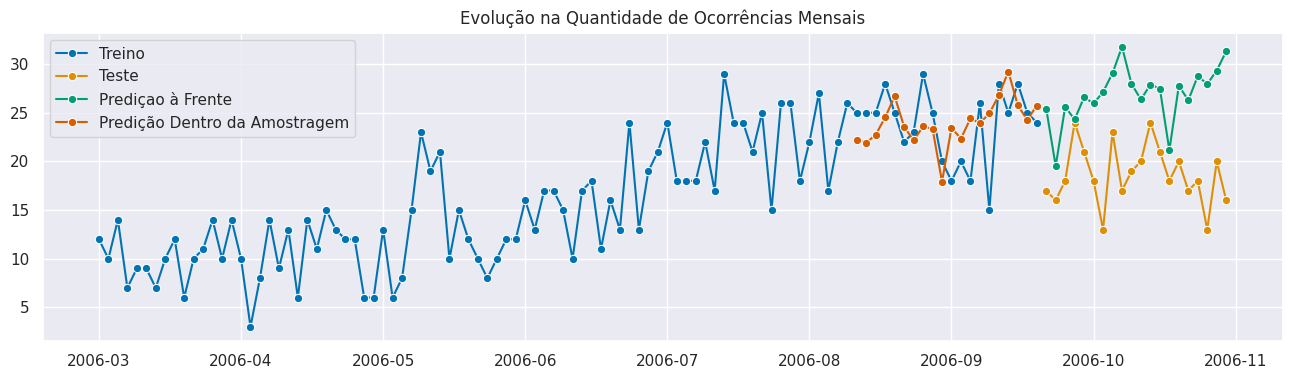

In [242]:
plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample)

#### Auto ETS

In [243]:
forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)

forecaster.fit(y_train)

y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

results_ets = {
    "MSE": mean_squared_error(y_test, y_pred_rel), 
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_rel), 
    "R2 Score": r2_score(y_test, y_pred_rel)
}

<ipython-input-203-30df11a6f6bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks.strftime('%Y-%m'))


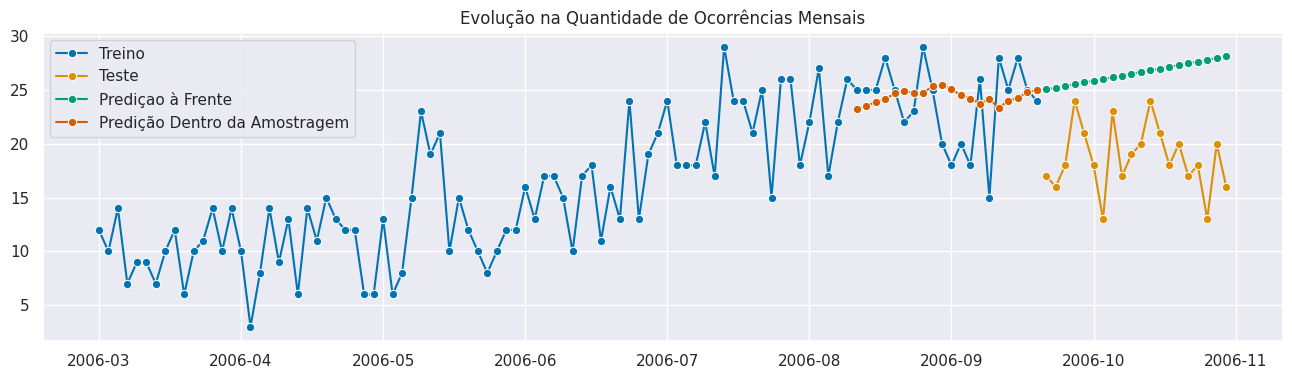

In [244]:
plot_ts(y_train, y_test, y_pred_rel, y_pred_rel_insample)

### Resultados

In [245]:
results_df = pd.DataFrame.from_dict([results_arima, results_es, results_fb, results_ets])
results_df = results_df.set_index(pd.Index(['ARIMA', 'EXP. SMOOTHING', 'PROPHET', 'ETS']))
results_df.head()

,MSE,MAPE,R2 Score
ARIMA,57.21489169,0.40378113,-5.33784455
EXP. SMOOTHING,73.36575346,0.46556221,-7.12691813
PROPHET,84.44830373,0.48147394,-8.35456148
ETS,73.36595129,0.46556288,-7.12694005


## Aeronaves

In [6]:
df = pd.merge(oc_df[['codigo_ocorrencia','classificacao', 'dia_ocorrencia']], aeronaves_df.copy(), on='codigo_ocorrencia')

df['ano_fabricacao'].fillna(0, inplace=True)
df.fillna('N/A', inplace=True)
df.replace('***', 'N/A', inplace=True)
df.replace('****', 'N/A', inplace=True)
df['ano_ocorrencia'] = pd.to_datetime(df['dia_ocorrencia']).dt.year
df['ano_fabricacao'] = df['ano_fabricacao'].astype(int)
df['idade'] = df['ano_ocorrencia'] - df['ano_fabricacao']

In [250]:
df.columns

Index(['codigo_ocorrencia', 'classificacao', 'dia_ocorrencia',
       'codigo_aeronave', 'matricula', 'codigo_operador', 'modelo',
       'quantidade_motores', 'peso_maximo_decolagem', 'quantidade_assentos',
       'ano_fabricacao', 'pais_registro', 'origem_voo', 'destino_voo',
       'quantidade_fatalidades', 'dia_extracao', 'ano_ocorrencia', 'idade',
       'equipamento', 'fabricante', 'tipo_motor', 'categoria_registro',
       'categoria_aviacao', 'fase_operacao', 'tipo_operacao', 'nivel_dano',
       'idade_grupo'],
      dtype='object')

In [8]:
columns = ['equipamento', 'fabricante', 'tipo_motor', 'categoria_registro',
       'categoria_aviacao', 'fase_operacao', 'tipo_operacao', 'nivel_dano']

LENGTH = len(df)
values_counts = {}
for col in columns:
  values_counts[col] = df[col].value_counts()


def categorize(value, values_counts):
    if value == 'N/A':
        return value
    count = values_counts.loc[value]    
    if count > (LENGTH * 0.05):
      return value
    return "OUTROS"

for col in columns:
  new_col = f'{col}_temp'
  df[new_col] = df.apply(lambda linha: categorize(linha[col], values_counts[col]), axis=1)
  df = df.drop(col, axis=1)
  df = df.rename(columns={new_col: col})

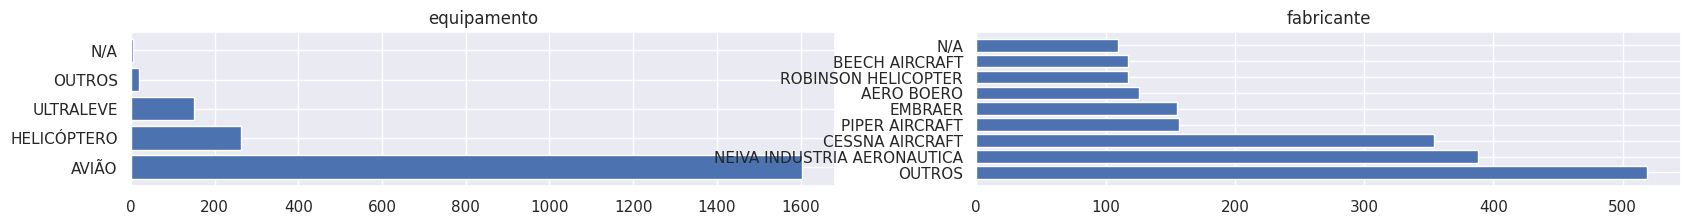

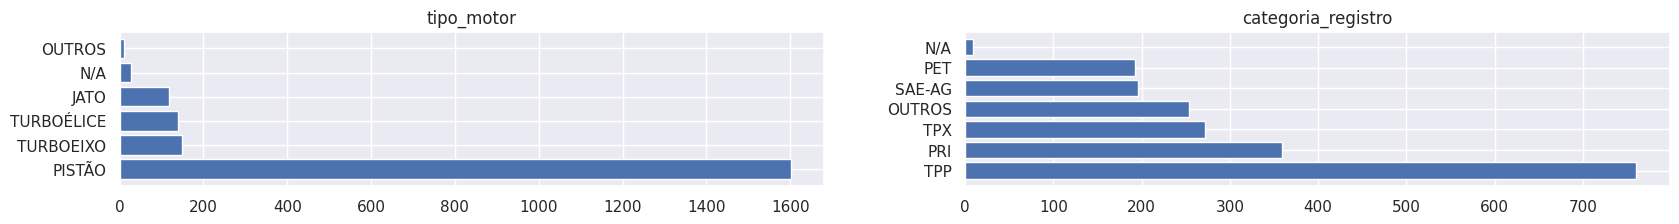

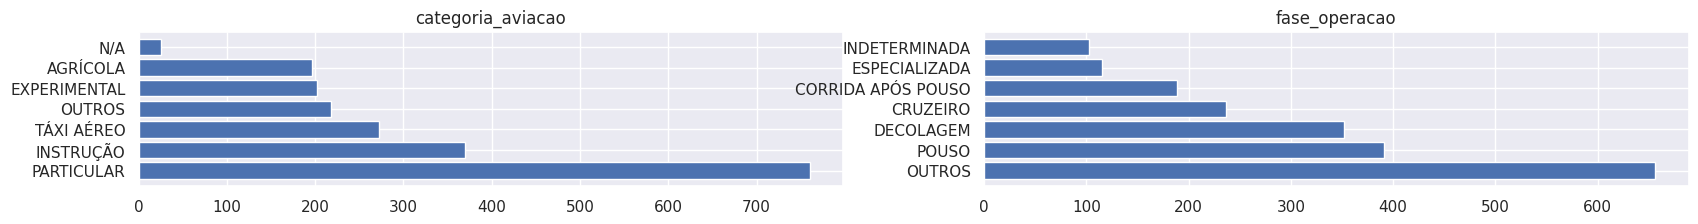

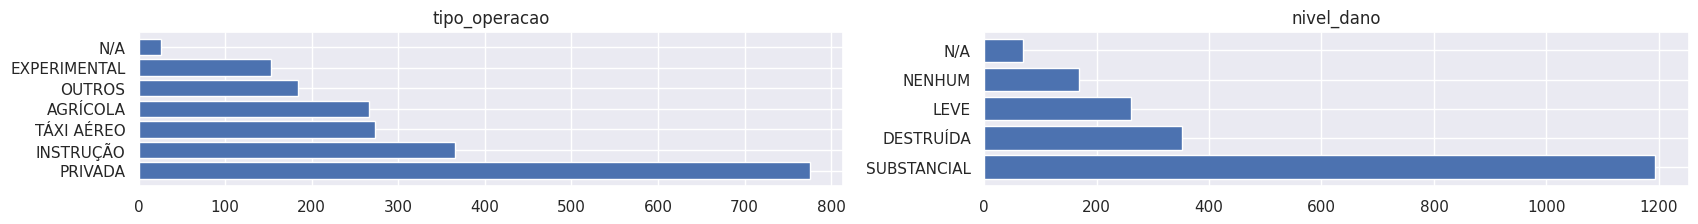

In [9]:
sns.set(rc={'figure.figsize':(18, 10)})

columns = ['equipamento', 'fabricante', 'tipo_motor', 'categoria_registro',
       'categoria_aviacao', 'fase_operacao', 'tipo_operacao', 'nivel_dano']
def plot_barh(df, columns):
  sns.set(rc={'figure.figsize':(20, 2)})
  # Create subplots
  fig, ax = plt.subplots(1,2)
  for i in range(2):
    col = columns[i]
    counts = df[col].value_counts()
    ax[i].barh(counts.index, counts.values)
    ax[i].set_title(col)
        
  # Set y-axis label and tight layout
  plt.show()

for i in range(0, len(columns), 2):
  plot_barh(df, columns[i:i+2])

In [10]:
# create age groups
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61+']
df['idade_grupo'] = pd.cut(df.loc[df['ano_fabricacao'] > 1900]['idade'], bins=bins, labels=labels)

<Axes: >

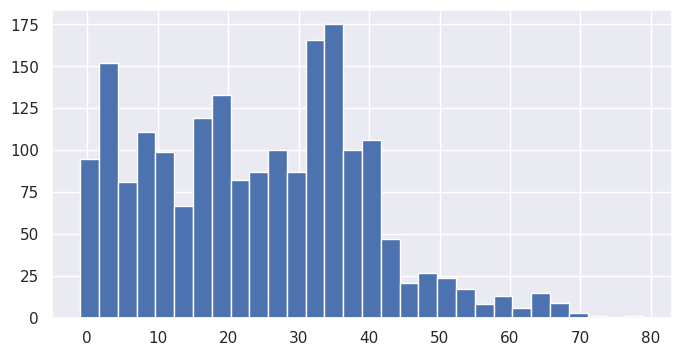

In [11]:
sns.set(rc={'figure.figsize':(8, 4)})
df.loc[df['ano_fabricacao'] > 1900]['idade'].hist(bins=30)

<Axes: >

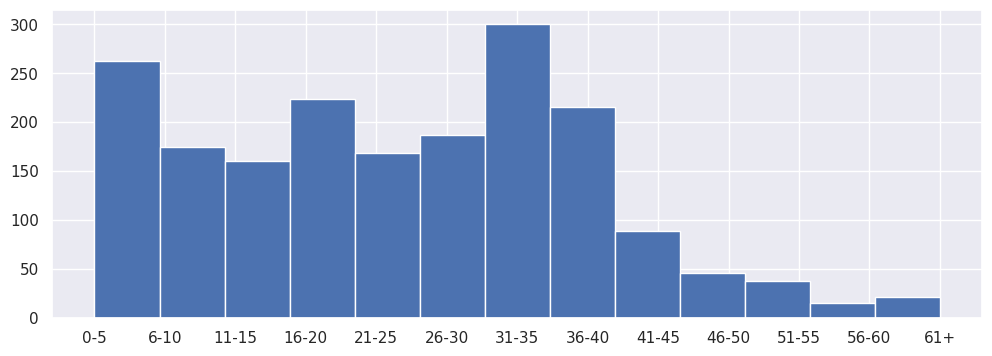

In [12]:
sns.set(rc={'figure.figsize':(12, 4)})
df['idade_grupo'].sort_values().hist(bins=13, align='mid')

### Classificação do Incidente

```
# This is formatted as code
```



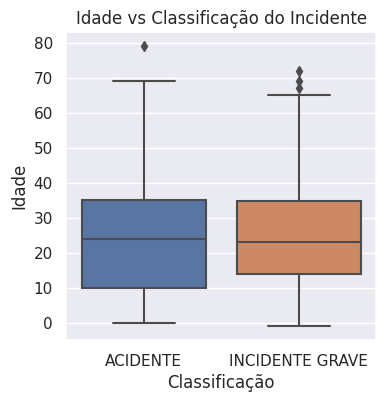

In [13]:
sns.set(rc={'figure.figsize':(4, 4)})
data=df.loc[df['ano_fabricacao'] > 1900]

sns.boxplot(data=data, x='classificacao', y='idade')
plt.title('Idade vs Classificação do Incidente')
plt.xlabel('Classificação')
plt.ylabel('Idade')
plt.show()

In [14]:
cont_table = pd.crosstab(data['idade_grupo'], data['classificacao'])
chi2, p, dof, expected = chi2_contingency(cont_table)

print(f"Chi-Square: {chi2:.2f}")
print(f"p-value: {p:.5f}")
print(f"Degrees of Freedom: {dof}")

Chi-Square: 29.47
p-value: 0.00336
Degrees of Freedom: 12


A falha na rejeição da hipótese nula implica que há correlação entre a idade do avião e a gravidade do acidente

### Nível de dano

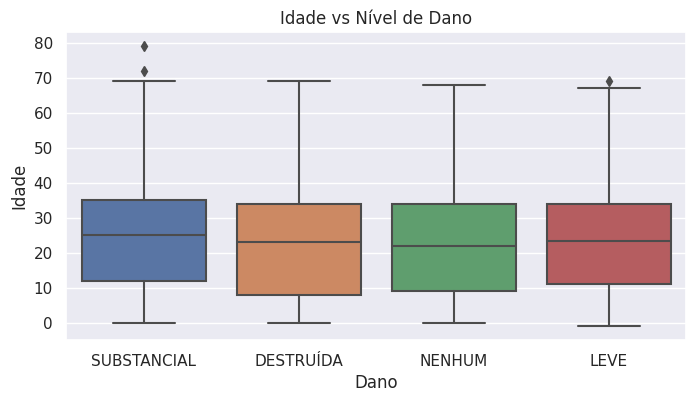

In [246]:
sns.set(rc={'figure.figsize':(8, 4)})
data=df.loc[(df['ano_fabricacao'] > 1900) & (df['nivel_dano'] != 'N/A')]

sns.boxplot(data=data, x='nivel_dano', y='idade')
plt.title('Idade vs Nível de Dano')
plt.xlabel('Dano')
plt.ylabel('Idade')
plt.show()

In [248]:
cont_table = pd.crosstab(data['idade_grupo'], data['nivel_dano'])
chi2, p, dof, expected = chi2_contingency(cont_table)

print(f"Chi-Square: {chi2:.2f}")
print(f"p-value: {p:.5f}")
print(f"Degrees of Freedom: {dof}")

Chi-Square: 37.56
p-value: 0.39737
Degrees of Freedom: 36


A rejeição da hipótese nula para o nível de confiança de 95% implica que o nível de dano e a idade da aeronave são independentes

### Regressão Logística

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE


In [18]:
columns = ['modelo',
       'quantidade_motores', 'peso_maximo_decolagem', 'quantidade_assentos',
       'ano_fabricacao', 'pais_registro', 'ano_ocorrencia', 'idade',
       'equipamento', 'fabricante', 'tipo_motor', 'categoria_registro',
       'categoria_aviacao', 'fase_operacao', 'tipo_operacao']

data = df.loc[df['ano_fabricacao'] > 1900]

regression_columns = []
for col in columns:
  l = len(data[col].unique())
  if l <= 20:
    regression_columns.append(col)

data = data[ ['classificacao'] + regression_columns]
data = data.drop(data[data.apply(lambda row: row.astype(str).str.contains('N/A').any(), axis=1)].index)
le = LabelEncoder()

#data['classificacao'] = data[col] = le.fit_transform(data['classificacao'])
for col in regression_columns:
  if data[col].dtype == 'object':
    data[col] = le.fit_transform(data[col])

Remoção de colunas de alta cardinalidade

In [19]:
data['classificacao'].value_counts()

ACIDENTE           1308
INCIDENTE GRAVE     528
Name: classificacao, dtype: int64

In [20]:
data.head()

,classificacao,quantidade_motores,pais_registro,ano_ocorrencia,equipamento,fabricante,tipo_motor,categoria_registro,categoria_aviacao,fase_operacao,tipo_operacao
0,ACIDENTE,1,0,2013,3,5,2,1,1,5,1
1,INCIDENTE GRAVE,2,0,2013,0,3,2,5,5,6,5
2,ACIDENTE,2,0,2008,0,3,2,5,5,0,5
3,ACIDENTE,1,0,2011,0,2,2,5,5,0,5
4,ACIDENTE,1,0,2009,0,2,2,0,3,2,3


In [21]:
def get_score(y_test, y_pred, pos_label):
  accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision
  precision = precision_score(y_test, y_pred, average="binary", pos_label=pos_label)

    # Calculate recall
  recall = recall_score(y_test, y_pred, average="binary", pos_label=pos_label)

    # Calculate F1-score
  f1_ = f1_score(y_test, y_pred, average="binary", pos_label=pos_label)

  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1-score": f1_
  }

In [22]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[regression_columns], data['classificacao'], test_size=0.3)
min_max_scaler = MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
x_test_scaled = pd.DataFrame(min_max_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train = x_scaled.round(4)
X_test = x_test_scaled.round(4)

In [23]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [24]:
zeror = DummyClassifier(strategy="most_frequent")
logistic = LogisticRegression(max_iter=10000)
knn = KNeighborsClassifier()
j48 = DecisionTreeClassifier()
rf = RandomForestClassifier()

zeror_predict = zeror.fit(X_resampled, y_resampled)
logistic_predict = logistic.fit(X_resampled, y_resampled)
knn_predict = knn.fit(X_resampled, y_resampled)
j48_predict = j48.fit(X_resampled, y_resampled)
rf_predict = rf.fit(X_resampled, y_resampled)

zeror_predict = zeror.predict(X_test)
logistic_predict = logistic.predict(X_test)
knn_predict = knn.predict(X_test)
j48_predict = j48.predict(X_test)
rf_predict = rf.predict(X_test)

In [25]:
index_list = ['DummyClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier']
results_df = pd.DataFrame()
results_df = results_df.append(get_score(zeror_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
results_df = results_df.append(get_score(logistic_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
results_df = results_df.append(get_score(knn_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
results_df = results_df.append(get_score(j48_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
results_df = results_df.append(get_score(rf_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
results_df.index = index_list

results_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-25-b648a56fd2a5>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(get_score(zeror_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
<ipython-input-25-b648a56fd2a5>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(get_score(logistic_predict, y_test, pos_label='INCIDENTE GRAVE'),ignore_index=True)
<ipython-input-25-b648a56fd2a5>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

,accuracy,precision,recall,f1-score
DummyClassifier,0.71869328,0.00000000,0.00000000,0.00000000
LogisticRegression,0.69147005,0.76129032,0.47011952,0.58128079
KNeighborsClassifier,0.65335753,0.67741935,0.42682927,0.52369077
DecisionTreeClassifier,0.70235935,0.47096774,0.47096774,0.47096774
RandomForestClassifier,0.71324864,0.49677419,0.49044586,0.49358974


In [26]:
index_list = ['DummyClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier']
results_df = pd.DataFrame()
results_df = results_df.append(get_score(zeror_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
results_df = results_df.append(get_score(logistic_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
results_df = results_df.append(get_score(knn_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
results_df = results_df.append(get_score(j48_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
results_df = results_df.append(get_score(rf_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
results_df.index = index_list

results_df.head()

<ipython-input-26-eee04c43cd7d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(get_score(zeror_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
<ipython-input-26-eee04c43cd7d>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(get_score(logistic_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
<ipython-input-26-eee04c43cd7d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(get_score(knn_predict, y_test, pos_label='ACIDENTE'),ignore_index=True)
<ipython-input-26-eee04c43cd7d>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resu

,accuracy,precision,recall,f1-score
DummyClassifier,0.71869328,1.00000000,0.71869328,0.83632524
LogisticRegression,0.69147005,0.66414141,0.87666667,0.75574713
KNeighborsClassifier,0.65335753,0.64393939,0.83606557,0.72753210
DecisionTreeClassifier,0.70235935,0.79292929,0.79292929,0.79292929
RandomForestClassifier,0.71324864,0.79797980,0.80203046,0.80000000


#### Curva Roc - Random Forest

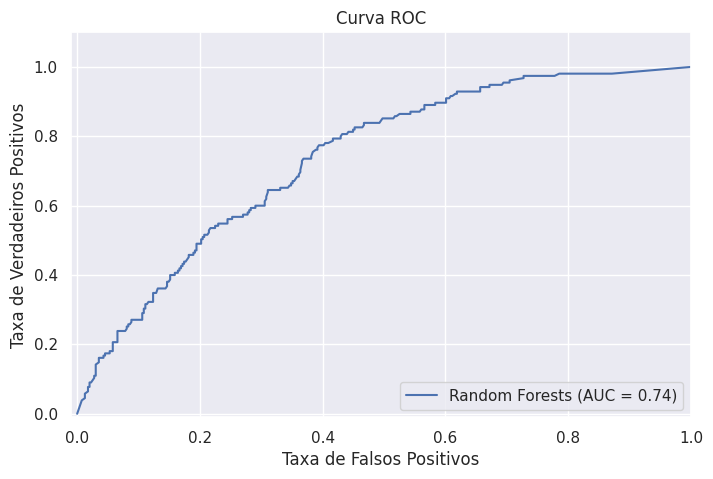

In [27]:
y_scores = rf.predict_proba(X_test)[:, 1]

# Calcula as taxas de verdadeiros positivos e falsos positivos em diferentes thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='INCIDENTE GRAVE')
roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(8, 5))

plt.plot(fpr, tpr, label='Random Forests (AUC = %0.2f)' % roc_auc)
plt.xlim([-0.01, 1])
plt.ylim([-0.01, 1.1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

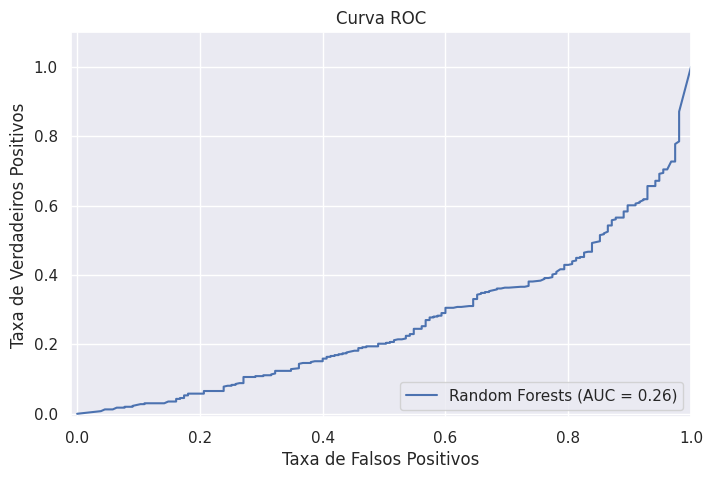

In [28]:
y_scores = rf.predict_proba(X_test)[:, 1]

# Calcula as taxas de verdadeiros positivos e falsos positivos em diferentes thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='ACIDENTE')
roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(8, 5))

plt.plot(fpr, tpr, label='Random Forests (AUC = %0.2f)' % roc_auc)
plt.xlim([-0.01, 1])
plt.ylim([-0.01, 1.1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [84]:
y_pred_prob = rf.predict_proba(X_test)
threshold = 0.26

# create an array of predicted classes based on the threshold
y_pred = (y_pred_prob[:, 1] >= threshold)
y_pred = np.array(['INCIDENTE GRAVE' if i>= threshold else 'ACIDENTE' for i in y_pred_prob[:, 1]])

In [85]:
get_score(y_pred, y_test, pos_label='INCIDENTE GRAVE')

{'accuracy': 0.6606170598911071,
 'precision': 0.7290322580645161,
 'recall': 0.437984496124031,
 'f1-score': 0.5472154963680388}